In [22]:
import pandas as pd
import numpy as np

import seaborn as sns
import warnings
from IPython.display import display, Markdown

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')

## Custom methods

In [23]:
# get the percentage of nulls on pandas dataframe
def val_pd_df_nan(df):
    flat_data = df.values.flatten()
    count=0
    for value in flat_data:
        if value is not None:
            continue
        count+= 1
    return round(100*count/len(flat_data))


## Load data
The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

The attribute names of the data have been anonymized for proprietary reasons. It consists of both single numerical counters and histograms consisting of bins with different conditions. Typically the histograms have open-ended conditions at each end. For example, if we measuring the ambient temperature "T" then the histogram could be defined with 4 bins where:

The attributes are as follows: class, then anonymized operational data. The operational data have an identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram variables. Missing values are denoted by "na".

In [24]:
train_ds = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv', na_values='na')
test_ds =  pd.read_csv('data/aps_failure_test_set_processed_8bit.csv', na_values='na')

train_labels = train_ds['class']
test_labels = test_ds['class']
train_features = train_ds.drop('class', axis=1)
test_features = test_ds.drop('class', axis=1)

print(train_labels.shape, test_labels.shape)
print(train_features.shape, test_features.shape)

(60000,) (16000,)
(60000, 170) (16000, 170)


In [25]:
train_ds

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.992188,0.640625,0.007812,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.476562,0.656250,0.718750,0.734375,0.640625,0.218750,0.992188,0.421875,-0.023438,-0.023438
59996,-0.992188,-0.390625,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.375000,-0.375000,-0.359375,-0.289062,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
59997,-0.992188,-0.406250,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
59998,-0.992188,0.140625,0.304688,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.218750,0.023438,-0.085938,-0.148438,-0.132812,-0.101562,0.992188,0.992188,-0.023438,-0.023438


In [26]:
print(f'{val_pd_df_nan(train_features)}% of train data are non-valid.')
print(f'{val_pd_df_nan(test_features)}% of test data are non-valid.')

0% of train data are non-valid.
0% of test data are non-valid.


In [27]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-0.124611,-0.071121,-0.198529,-0.007737,-0.033483,-0.040633,-0.006584,-0.026241,-0.040699,-0.074768,...,-0.104808,-0.098734,-0.094976,-0.089227,-0.103374,-0.088961,-0.084540,-0.067471,-0.020035,-0.018417
std,0.367680,0.356812,0.564872,0.004138,0.107086,0.111752,0.032016,0.065200,0.105864,0.186822,...,0.356547,0.362066,0.363148,0.336121,0.320314,0.237613,0.363893,0.261009,0.051907,0.061751
min,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.382812,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
25%,-0.398438,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.382812,-0.382812,-0.375000,-0.343750,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
50%,-0.195312,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.179688,-0.179688,-0.195312,-0.179688,-0.226562,-0.171875,-0.296875,-0.171875,-0.023438,-0.023438
75%,-0.070312,-0.000000,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.031250,-0.054688,-0.117188,...,-0.007812,0.015625,0.015625,0.007812,-0.054688,-0.101562,-0.000000,-0.132812,-0.023438,-0.023438
max,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,...,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188,0.992188


In [28]:
scaler = MinMaxScaler()
scaler.fit(train_features)
train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)

In [29]:
train_features.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.201396,0.170101,0.184964,0.000076,0.012888,0.013425,0.001228,0.004894,0.013362,0.038237,...,0.202185,0.206603,0.209336,0.195227,0.160288,0.089559,0.169752,0.089689,0.003350,0.004943
std,0.262922,0.278488,0.386650,0.004138,0.103060,0.106749,0.032016,0.063707,0.101124,0.168403,...,0.259307,0.263321,0.264107,0.250137,0.245510,0.200095,0.280592,0.224222,0.051108,0.060801
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005682,0.005814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.147727,0.147727,0.136364,0.127907,0.065868,0.019737,0.006024,0.000000,0.000000,0.000000
75%,0.240223,0.225610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.272727,0.289773,0.289773,0.267442,0.197605,0.078947,0.234940,0.033557,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
train_labels = train_labels.apply(round)
train_labels = train_labels.replace({-1:0})

In [31]:
train_labels.value_counts()

0    59000
1     1000
Name: class, dtype: int64

## Correlation Heatmap

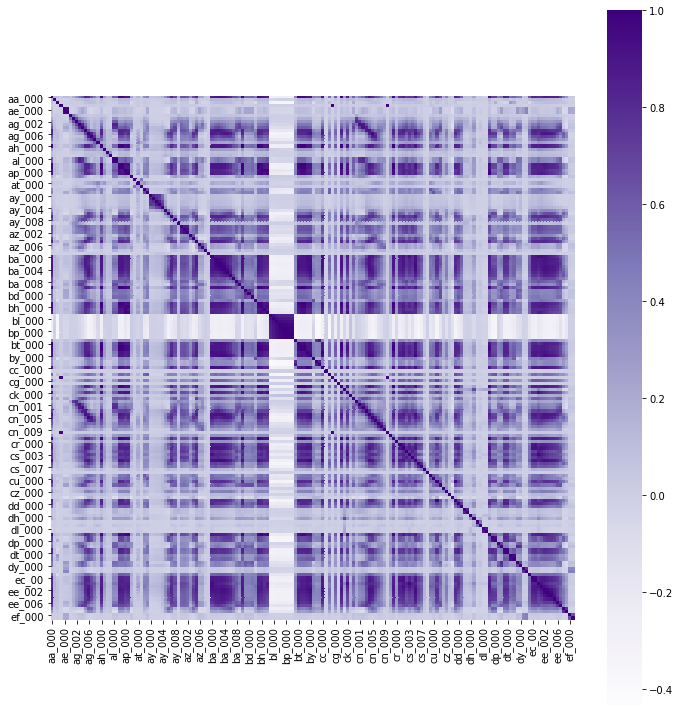

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
corr_matrix = train_features.corr()
ax = sns.heatmap(corr_matrix, square=True, cmap='Purples', ax=ax)
plt.tight_layout()
plt.show()

## Select KBest

In [12]:
# k_best = 84
# selectKBest = SelectKBest(chi2, k_best)
# selectKBest.fit(train_features, train_labels)
# best_train_features = selectKBest.transform(train_features)

# idxs_selected = selectKBest.get_support(indices=True)
# best_train_features = train_features.iloc[:,idxs_selected]

# print(best_train_features.columns)

Index(['aa_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ah_000',
       'ai_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000',
       'ar_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_007', 'ay_008',
       'ay_009', 'az_000', 'az_001', 'az_002', 'az_005', 'ba_000', 'ba_001',
       'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_008', 'ba_009',
       'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000',
       'bi_000', 'bj_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000',
       'cc_000', 'ci_000', 'cj_000', 'ck_000', 'cl_000', 'cm_000', 'cn_000',
       'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_007', 'cn_008', 'cn_009',
       'cq_000', 'cs_001', 'cs_002', 'cs_003', 'cs_004', 'cs_005', 'cx_000',
       'dd_000', 'df_000', 'dn_000', 'dq_000', 'eb_000', 'ec_00', 'ee_000',
       'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007'],
      dtype='object')


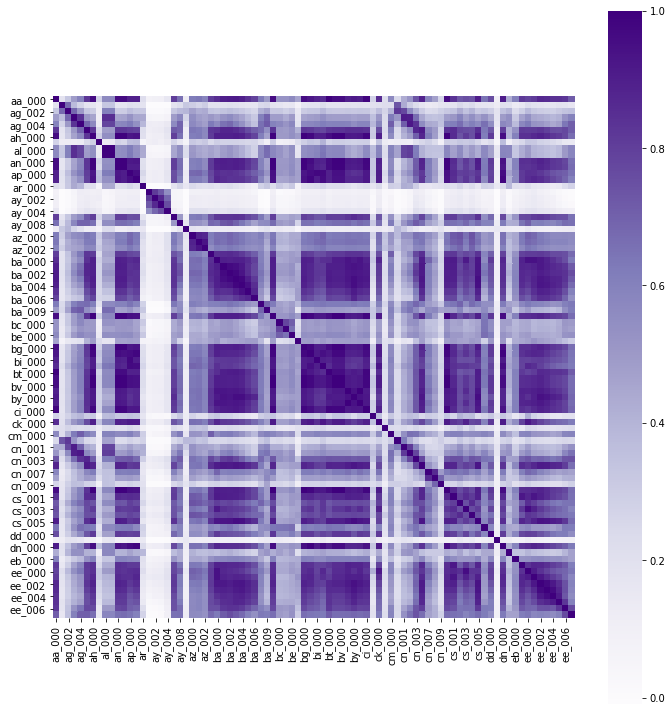

In [13]:
# fig, ax = plt.subplots(figsize=(10,10))
# new_corr_matrix = best_train_features.corr()
# ax = sns.heatmap(new_corr_matrix, square=True, cmap='Purples', ax=ax)
# plt.tight_layout()
# plt.show()

In [14]:
# pca_variance = 0.95 

# pca = PCA(pca_variance)
# pca.fit(train_features)
# best_train_features = pca.transform(train_features)
# best_train_features = pd.DataFrame(best_train_features)

# print(f'Number of components {pca.n_components_}')

Number of components 48


## Sampling

In [15]:
# number_samples = 2500

# idxs_pos = train_labels[train_labels==1].index
# idxs_neg = train_labels[train_labels==0].sample(n=number_samples, replace=False, random_state=0).index
# idxs_balanced = np.concatenate((idxs_pos,idxs_neg))
# best_train_features_balanced = best_train_features.loc[idxs_balanced]
# train_labels_balanced = train_labels.loc[idxs_balanced]
# print(f'Proportion balanced: {int(number_samples/1000)}/1')

## Feature selection with Boruta

In [36]:
from boruta import boruta_py

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = boruta_py.BorutaPy(forest, n_estimators='auto', verbose=2, random_state=123)

# find all relevant features
feat_selector.fit(train_features.values, train_labels.values)

# check selected features
print(feat_selector.support_)

# check ranking of features
print(feat_selector.ranking_)

# # call transform() on X to filter it down to selected features
# X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	170
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	105
Tentative: 	36
Rejected: 	29
Iteration: 	9 / 100
Confirmed: 	105
Tentative: 	36
Rejected: 	29
Iteration: 	10 / 100
Confirmed: 	105
Tentative: 	36
Rejected: 	29
Iteration: 	11 / 100
Confirmed: 	105
Tentative: 	36
Rejected: 	29
Iteration: 	12 / 100
Confirmed: 	111
Tentative: 	30
Rejected: 	29
Iteration: 	13 / 100
Confirmed: 	111
Tentative: 	22
Rejected: 	37
Iteration: 	14 / 100
Confirmed: 	111
Tentative: 	22
Rejected: 	37
Iteration: 	15 / 100
Confirmed: 	111
Tentative: 	22
Rejected: 	37
Iteration: 	16 / 100
Confirmed: 	